This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Extrapolate projection centers from a mean

In this tutorial, we will extrapolate a plane of projection centers (PCs) from a mean PC, as determined from patterns spread out across the sample region of interest.
This is an alternative to *fitting* a plane to PCs, as done in the tutorial [Fit a plane to selected projection centers](pc_fit_plane.ipynb).
As a verification of the extrapolated PCs, we will compare them to the PCs obtained from fitting a plane to the PCs as is done in that tutorial.

We'll start by importing the necessary libraries

In [1]:
%matplotlib inline

from diffsims.crystallography import ReciprocalLatticeVector
import hyperspy.api as hs
import kikuchipy as kp
import matplotlib.pyplot as plt
import numpy as np
from orix.crystal_map import CrystalMap, PhaseList
from orix.quaternion import Rotation
from pyebsdindex import ebsd_index, pcopt


plt.rcParams.update(
    {
        "figure.facecolor": "w",
        "figure.dpi": 75,
        "figure.figsize": (8, 8),
        "font.size": 15,
    }
)

## Load and inspect data

We will use nine calibration patterns from recrystallized nickel.
The patterns have the full (480, 480) px$^2$ resolution of the NORDIF UF-1100 detector they are acquired on.
These patterns are always acquired from spread out sample positions across the region of interest (ROI) in order to calibrate the PCs prior to indexing the full dataset.

Read the calibration patterns

In [2]:
s_cal = kp.data.ni_gain0_calibration(allow_download=True)
s_cal

<EBSD, title: Calibration patterns, dimensions: (9|480, 480)>

Get information read with NORDIF calibration patterns

In [3]:
omd = s_cal.original_metadata.as_dictionary()

Plot coordinates of calibration patterns on the secondary electron area overview image (part of the dataset), highlighting the region of interest (ROI)

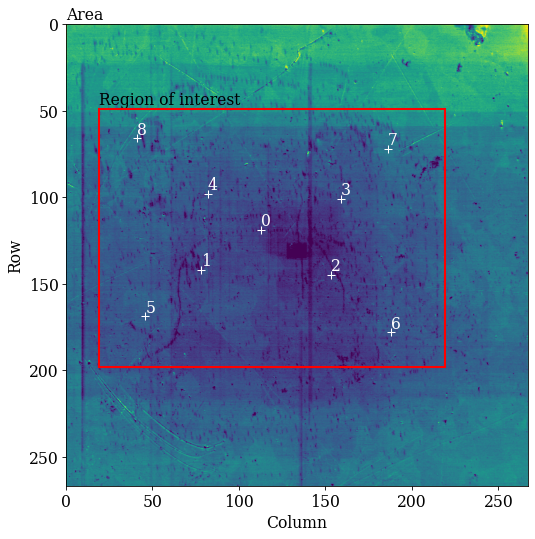

In [4]:
kp.draw.plot_pattern_positions_in_map(
    rc=omd["calibration_patterns"]["indices_scaled"],
    roi_shape=omd["roi"]["shape_scaled"],
    roi_origin=omd["roi"]["origin_scaled"],
    area_shape=omd["area"]["shape_scaled"],
    area_image=omd["area_image"],
    color="w",
)

Plot the nine calibration patterns

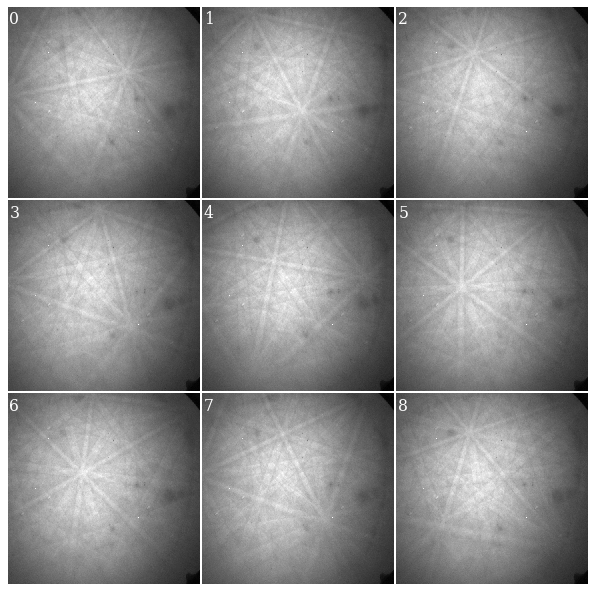

In [5]:
fig = plt.figure(figsize=(10, 10))
_ = hs.plot.plot_images(
    s_cal,
    per_row=3,
    axes_decor=None,
    colorbar=False,
    label=None,
    fig=fig,
)
for i, ax in enumerate(fig.axes):
    ax.axis("off")
    ax.text(5, 10, str(i), va="top", ha="left", c="w")
fig.subplots_adjust(wspace=0.01, hspace=0.01)

Improve signal-to-noise ratio by removing the static and dynamic background

In [6]:
s_cal.remove_static_background()
s_cal.remove_dynamic_background()

[########################################] | 100% Completed | 103.99 ms
[########################################] | 100% Completed | 101.18 ms


Get an initial EBSD detector to store PC values in

In [7]:
det_cal = s_cal.detector

print(det_cal)
print(det_cal.sample_tilt)

EBSDDetector (480, 480), px_size 1 um, binning 1, tilt 0.0, azimuthal 0.0, pc (0.5, 0.5, 0.5)
70.0


Set up indexer for Hough indexing with PyEBSDIndex

In [8]:
indexer_cal = ebsd_index.EBSDIndexer(
    phaselist=["FCC"],
    vendor="kikuchipy",
    sampleTilt=det_cal.sample_tilt,
    camElev=det_cal.tilt,
    patDim=det_cal.shape,
)

Prepare patterns for Hough indexing

In [9]:
patterns_cal = s_cal.data.reshape((-1,) + det_cal.shape)

Estimate PCs with Hough indexing, also checking the standard deviation

In [10]:
pc0 = [0.4, 0.2, 0.5]
pcs = pcopt.optimize(
    pats=patterns_cal,
    indexer=indexer_cal,
    PC0=pc0,
    batch=True,
)

print(pcs.mean(axis=0))
print(pcs.std(0))

[0.42077662 0.2182365  0.49993497]
[0.0072175  0.00801777 0.00784516]


Add the PCs to the detector, and plot them

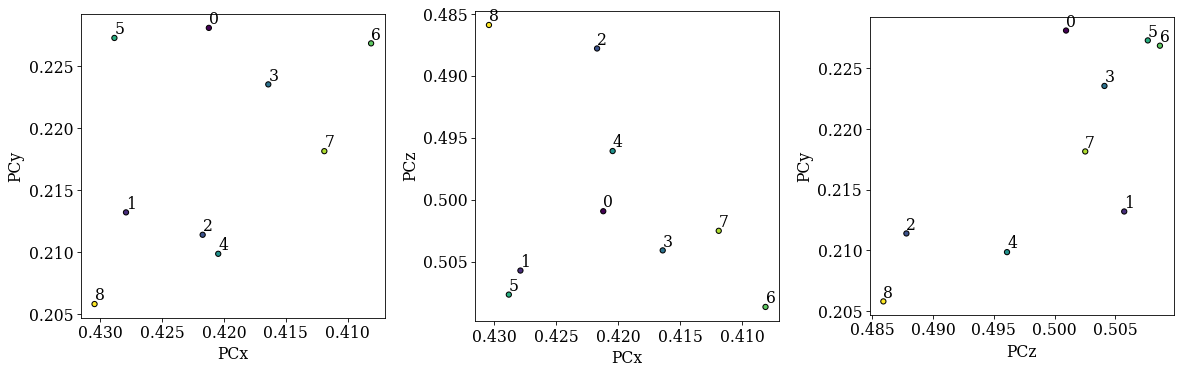

In [11]:
det_cal.pc = pcs
det_cal.plot_pc("scatter", annotate=True)

Unfortunately, we do not recognize the spatial distribution from the overview image above, and the expected inverse relation between (PCz, PCy) is not present...
We need better indexing of the patterns, which we get by refining the PCs using pattern matching with dynamical simulations.
These simulations are created with EMsoft.

First, we need an initial guess for the orientations, using Hough indexing.
We will use the mean PC for all patterns

In [12]:
det_cal.pc = det_cal.pc_average

Radon Time: 0.03579442399495747
Convolution Time: 0.003661308997834567
Peak ID Time: 0.001747075999446679
Band Label Time: 0.043066815997008234
Total Band Find Time: 0.08430450000014389


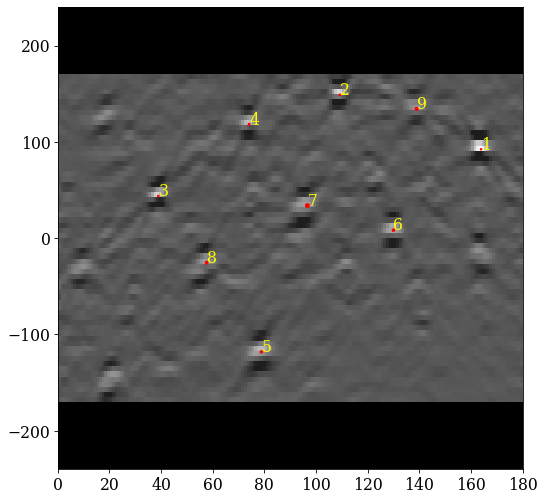

Band Vote Time:  0.02560122899740236


In [13]:
plt.figure()
hi_cal, *_ = indexer_cal.index_pats(
    patsin=patterns_cal, PC=det_cal.pc, verbose=2
)

For easy handling of the returned data, we add it to a [CrystalMap](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.CrystalMap.html).
This map needs a description of the [Phase](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.Phase.html).
In this case, we will use the one loaded with the dynamically simulated master pattern, which we need for refinement

In [14]:
mp = kp.data.ni_ebsd_master_pattern(
    allow_download=True, projection="lambert", energy=20
)
mp

<EBSDMasterPattern, title: ni_mc_mp_20kv, dimensions: (|1001, 1001)>

Extract the phase, and change the lattice parameter unit from nm to Ångström

In [15]:
phase = mp.phase

lat = phase.structure.lattice
lat.setLatPar(lat.a * 10, lat.b * 10, lat.c * 10)

In [16]:
print(phase)
print(phase.structure)

<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>
lattice=Lattice(a=3.5236, b=3.5236, c=3.5236, alpha=90, beta=90, gamma=90)
28   0.000000 0.000000 0.000000 1.0000


We can now create our crystal map, and print the mean pattern fit (misfit, really) and mean confidence metric (similar to the better known "confidence index")

In [17]:
hi_cal_best = hi_cal[-1]

xmap_hi = CrystalMap(
    rotations=Rotation(hi_cal_best["quat"]),
    phase_list=PhaseList(phase),
    prop=dict(
        pq=hi_cal_best["pq"],
        cm=hi_cal_best["cm"],
        fit=hi_cal_best["fit"],
        nmatch=hi_cal_best["nmatch"],
    ),
)

print(xmap_hi)
print(xmap_hi.fit.mean())
print(xmap_hi.cm.mean())

Phase  Orientations  Name  Space group  Point group  Proper point group     Color
    0    9 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: pq, cm, fit, nmatch
Scan unit: px
0.499941
0.65295005


Refine the PCs (and orientations) using the Nelder-Mead implementation from NLopt

In [18]:
xmap_ref, det_ref = s_cal.refine_orientation_projection_center(
    xmap=xmap_hi,
    detector=det_cal,
    master_pattern=mp,
    energy=20,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5, 0.05, 0.05, 0.05],
    rtol=1e-7,
    # A pattern per iteration to use all CPUs
    chunk_kwargs=dict(chunk_shape=1),
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5.   5.   5.   0.05 0.05 0.05]
  Relative tolerance: 1e-07
Refining 9 orientation(s) and projection center(s):
[########################################] | 100% Completed | 76.54 ss
Refinement speed: 0.11757 patterns/s


Inspect some refinement statistics

In [19]:
print("Score mean:", xmap_ref.scores.mean())
print("PC mean:\t", det_ref.pc.mean(0))
print("PC std:\t\t", det_ref.pc.std(0))
print("PC max. diff:\t", abs(det_cal.pc - det_ref.pc).max(0))

ori_diff = xmap_hi.orientations.angle_with(xmap_ref.orientations).max()
print("Ori. max. diff [deg]:", np.rad2deg(ori_diff))

Score mean: 0.5265935262044271
PC mean:	 [0.419984   0.21325313 0.50127493]
PC std:		 [0.00268396 0.00189127 0.00061867]
PC max. diff:	 [0.00483702 0.00809569 0.00252912]
Ori. max. diff [deg]: 1.4070065402331744


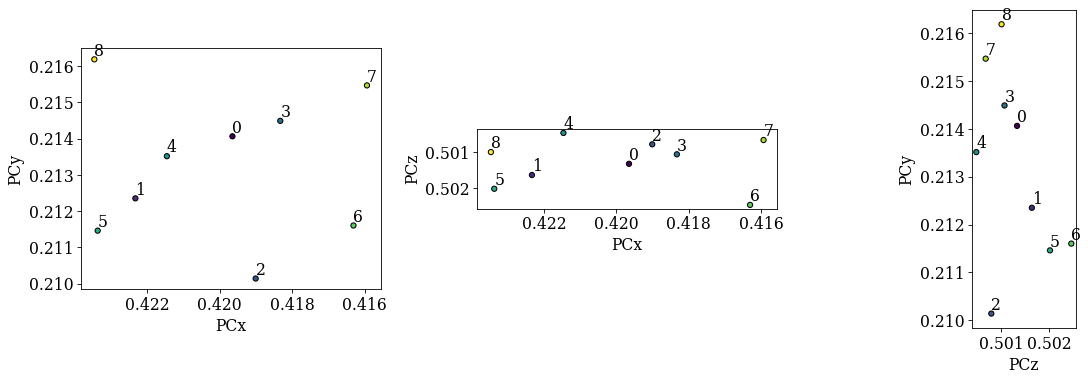

In [20]:
det_ref.plot_pc("scatter", annotate=True)

The diagonals 5-1-0-3-7 and 8-4-0-2-6 seen in the overview image above should be replicated in the (PCx, PCy) scatter plot.
We see that 5-1-0-3-7 and 8-0-6 align as expected, but the PC values from the 2nd and 4th patterns do not lie in the expected range.
Fitting a plane to all these values might not work to our satisfaction, so we will exclude the 2nd and 4th PC values when fitting a plane to the seven remaining PC values.
The plane will have PC values for all points in the ROI in the overview image above.

In [21]:
is_outlier = np.zeros(det_ref.navigation_size, dtype=bool)
is_outlier[[2, 4]] = True

## Get PC plane by fitting

The fitting is done by finding a transformation function which takes 2D sample coordinates and gives PC values for those coordinates.
Both an affine and a projective transformation function is supported, following <cite data-cite="winkelmann2020refined">Winkelmann et al. (2020)</cite>.
By passing 2D indices of all ROI map points and of the points where the nine calibration patterns were obtained, [EBSDDetector.fit_pc()](../reference/generated/kikuchipy.detectors.EBSDDetector.fit_pc.rst) returns a new detector with PC values for all map points.
We will use the maximum difference between the above refined PC values and the corresponding fitted PC values as a measure of how good the fitted PC values are.

In [22]:
pc_indices = omd["calibration_patterns"]["indices_scaled"]
pc_indices -= omd["roi"]["origin_scaled"]
pc_indices = pc_indices.T

map_indices = np.indices(omd["roi"]["shape_scaled"])
print("Full map shape (n rows, n columns):", omd["roi"]["shape_scaled"])

Full map shape (n rows, n columns): (149, 200)


Fit PC values using the affine transformation function

[0.41978491 0.21357867 0.5014836 ]
72.15608114216586


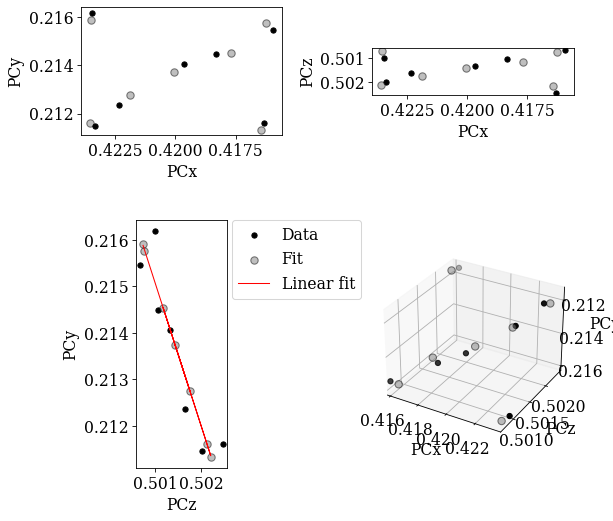

In [23]:
det_fit_aff = det_ref.fit_pc(
    pc_indices=pc_indices,
    map_indices=map_indices,
    transformation="affine",
    is_outlier=is_outlier,
)

print(det_fit_aff.pc_average)
print(det_fit_aff.sample_tilt)

Fit PC values using the projective transformation function

[0.41978318 0.21357788 0.5014831 ]
72.82078773971014


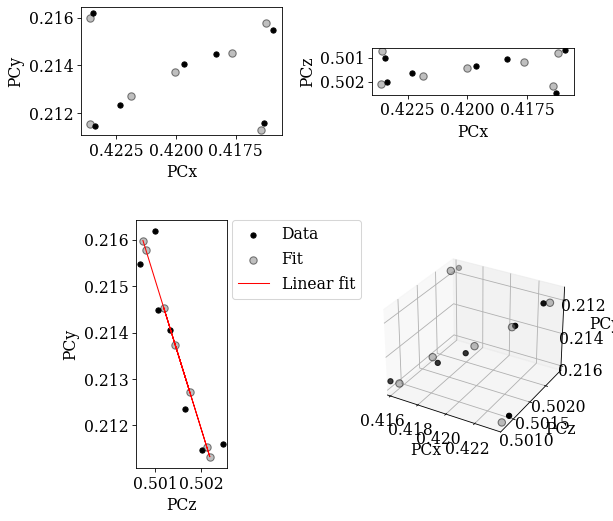

In [24]:
det_fit_proj = det_ref.fit_pc(
    pc_indices=pc_indices,
    map_indices=map_indices,
    transformation="projective",
    is_outlier=is_outlier,
)

print(det_fit_proj.pc_average)
print(det_fit_proj.sample_tilt)

Compare PC differences of all but the PC values from the 2nd and 4th patterns

In [25]:
pc_indices2 = pc_indices.T[~is_outlier].T

# Refined PC values as a reference (ground truth)
pc_ref = det_ref.pc[~is_outlier]

# Difference in PC values from the affine transformation function
pc_diff_aff = det_fit_aff.pc[tuple(pc_indices2)] - pc_ref
pc_diff_aff_max = abs(pc_diff_aff).max(axis=0)
print(pc_diff_aff_max)

# Difference in PC values from the projective transformation function
pc_diff_proj = det_fit_proj.pc[tuple(pc_indices2)] - pc_ref
pc_diff_proj_max = abs(pc_diff_proj).max(axis=0)
print(pc_diff_proj_max)

# Is the difference from the affine transformation function greater than
# that from the projective one for (PCx, PCy, PCz)?
print(pc_diff_aff_max > pc_diff_proj_max)

[0.00064475 0.00040066 0.00026409]
[0.00067924 0.00037354 0.00028272]
[False  True False]


## Get PC plane by extrapolation

Instead of fitting a plane to several PCs, we can extrapolate an average PC using [EBSDDetector.extrapolate_pc()](../reference/generated/kikuchipy.detectors.EBSDDetector.extrapolate_pc.rst).
To do this we need to know the detector pixel size and map step sizes, both given in the same unit.

In [26]:
det_ext = det_ref.extrapolate_pc(
    pc_indices=pc_indices.T,
    navigation_shape=omd["roi"]["shape_scaled"],
    step_sizes=(1.5, 1.5),  # um
    shape=det_cal.shape,
    px_size=70,  # In um. This is unique for every detector model!
    is_outlier=is_outlier,
)

print(det_ext.pc_average)
print(det_ext.sample_tilt)

[0.41980088 0.21357649 0.5014881 ]
70.0


Difference in PC values between the refined PCs and the corresponding extrapolated PCs

In [27]:
pc_diff_ext = det_ext.pc[tuple(pc_indices2)] - pc_ref
pc_diff_ext_max = abs(pc_diff_ext).max(axis=0)
print(pc_diff_ext_max)
print(pc_diff_ext_max > pc_diff_aff_max)

[0.00084788 0.00042755 0.00038862]
[ True  True  True]


The extrapolated PCs deviate more from the refined PCs than the PCs obtained from fitting, although the difference is small.

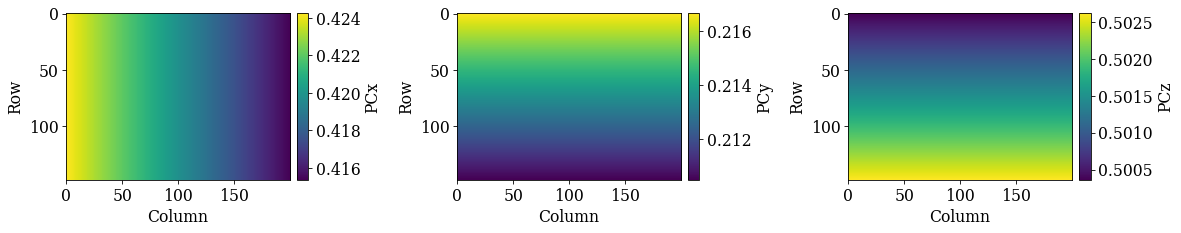

In [28]:
det_ext.plot_pc()

## Validate extrapolated PCs

As a final check of the difference in PCs, we can plot the geometrical simulations on top of the patterns using the refined orientation but the three different PCs.

In [29]:
rlv = ReciprocalLatticeVector.from_min_dspacing(phase)

rlv.sanitise_phase()  # "Fill atoms in unit cell"

rlv.calculate_structure_factor()

structure_factor = abs(rlv.structure_factor)
rlv = rlv[structure_factor > 0.5 * structure_factor.max()]

rlv.print_table()

 h k l      d     |F|_hkl   |F|^2   |F|^2_rel   Mult 
 1 1 1    2.034    11.8     140.0     100.0      8   
 2 0 0    1.762    10.4     108.2      77.3      6   
 2 2 0    1.246     7.4     55.0       39.3      12  
 3 1 1    1.062     6.2     38.6       27.6      24  


In [30]:
simulator = kp.simulations.KikuchiPatternSimulator(rlv)

We will use a signal mask during refinement to exclude pattern intensities in the detector corners

In [31]:
signal_mask = ~kp.filters.Window("circular", shape=det_cal.shape).astype(
    bool
)

Using PCs from the affine transformation function

In [32]:
det_aff_cal = det_fit_aff.deepcopy()
det_aff_cal.pc = det_aff_cal.pc[tuple(pc_indices)]

In [33]:
xmap_aff = s_cal.refine_orientation(
    xmap=xmap_hi,
    detector=det_aff_cal,
    master_pattern=mp,
    energy=20,
    signal_mask=signal_mask,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5],
    rtol=1e-7,
    # A pattern per iteration to use all CPUs
    chunk_kwargs=dict(chunk_shape=1),
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5 5 5]
  Relative tolerance: 1e-07
Refining 9 orientation(s):
[########################################] | 100% Completed | 15.15 ss
Refinement speed: 0.59373 patterns/s


In [34]:
sim_aff = simulator.on_detector(det_aff_cal, xmap_aff.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 102.47 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 101.35 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 101.67 ms


Using PCs from the projective transformation function

In [35]:
det_proj_cal = det_fit_proj.deepcopy()
det_proj_cal.pc = det_proj_cal.pc[tuple(pc_indices)]

In [36]:
xmap_proj = s_cal.refine_orientation(
    xmap=xmap_hi,
    detector=det_proj_cal,
    master_pattern=mp,
    energy=20,
    signal_mask=signal_mask,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5],
    rtol=1e-7,
    # A pattern per iteration to use all CPUs
    chunk_kwargs=dict(chunk_shape=1),
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5 5 5]
  Relative tolerance: 1e-07
Refining 9 orientation(s):
[########################################] | 100% Completed | 16.00 ss
Refinement speed: 0.56248 patterns/s


In [37]:
sim_proj = simulator.on_detector(det_proj_cal, xmap_proj.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 101.66 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 102.47 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 102.89 ms


Using the extrapolated PCs

In [38]:
det_ext_cal = det_ext.deepcopy()
det_ext_cal.pc = det_ext_cal.pc[tuple(pc_indices)]

In [39]:
xmap_ext = s_cal.refine_orientation(
    xmap=xmap_hi,
    detector=det_ext_cal,
    master_pattern=mp,
    energy=20,
    signal_mask=signal_mask,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5],
    rtol=1e-7,
    # A pattern per iteration to use all CPUs
    chunk_kwargs=dict(chunk_shape=1),
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5 5 5]
  Relative tolerance: 1e-07
Refining 9 orientation(s):
[########################################] | 100% Completed | 15.00 ss
Refinement speed: 0.59962 patterns/s


In [40]:
sim_ext = simulator.on_detector(det_ext_cal, xmap_ext.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 101.60 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 101.80 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 105.17 ms


Compare normalized cross-correlation scores

In [41]:
print(f"Affine:\t\t{xmap_aff.scores.mean():.7f}")
print(f"Projective:\t{xmap_proj.scores.mean():.7f}")
print(f"Extrapolated:\t{xmap_ext.scores.mean():.7f}")

Affine:		0.5692973
Projective:	0.5692997
Extrapolated:	0.5692836


Plot Kikuchi bands on top of patterns for the solutions using the affine transformed PCs (red), projective transformed PCs (blue) and extrapolated PCs (white)

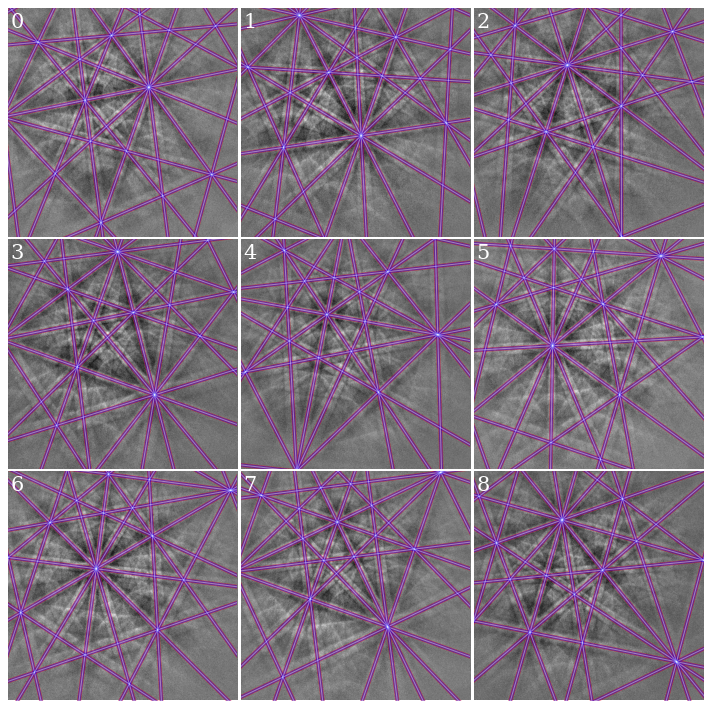

In [42]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(s_cal.inav[i].data, cmap="gray")
    ax.axis("off")

    # Affine
    lines = sim_aff.as_collections(
        i, lines_kwargs=dict(linewidth=4, alpha=0.4)
    )[0]
    ax.add_collection(lines)

    # Projective
    lines = sim_proj.as_collections(
        i, lines_kwargs=dict(color="b", linewidth=3, alpha=0.4)
    )[0]
    ax.add_collection(lines)

    # Extrapolated
    lines = sim_ext.as_collections(
        i, lines_kwargs=dict(color="w", linewidth=1, alpha=0.4)
    )[0]
    ax.add_collection(lines)

    ax.text(5, 10, i, c="w", va="top", ha="left", fontsize=20)
fig.subplots_adjust(wspace=0.01, hspace=0.01)

As expected from the intermediate results above (similar PCs and mean NCC score), all PCs produce visually identical geometrical simulations.
However, the orientations are still slightly different, as we see by calculating the misorientation angles between the orientations obtained using the extrapolated PCs and the fitted PCs

In [43]:
np.rad2deg(xmap_proj.orientations.angle_with(xmap_ext.orientations))

array([2.82059731, 2.81394722, 2.82132322, 2.82536381, 2.82220957,
       2.80746251, 2.81883009, 2.82924247, 2.82642146])

A misorientation of almost 3$^{\circ}$ is significant.
Since these are experimental data, it's difficult to say which orientations are more correct for the grains from which the calibration patterns were obtained.
A test with known orientations with respect to the sample reference frame should be done in order to test which PCs are more correct.